# Art Painting 이미지를 사용한 정확도 올리기

## <문제>

제공된 훈련데이터를 사용하여 모델을 훈련한 후 테스트 데이터에 대한 예측 카테고리 값을 csv파일로 제출하세요.

아래의 훈련데이터만을 사용하여 각 카테고리별로 분류가 잘 되도록 신경망을 구성하세요.
각 카테고리 별 정답 값은 아래와 같습니다.

- 'dog' : 0
- 'elephant' : 1
- 'giraffe' : 2
- 'guitar' : 3
- 'horse' : 4
- 'house' : 5
- 'person' : 6

## <목적>

주어진 데이터를 활용하여 정확도를 최대로 높이세요.

## 데이터 설명

데이터 셋은 art painting으로 구성되어 있으며 7개의 카테고리로 구분되어 있습니다.

7개의 카테고리로는 classes에서 정의한 dog, elephant, giraffe, guitar, horse, house, person를 포함합니다.

하나의 이미지의 사이즈는 [3(Channel) * 227(Width) * 227(Height)]이며 각 카테고리 별 예시 이미지는 아래에서 확인할 수 있습니다.

훈련 데이터는 art painting 1698장이며 테스트 데이터는 art painting 350장입니다.

## <최종 제출 파일과 코드>

- submission.csv

최종 제출 파일은 label 필드를 가지는 csv파일이며 테스트 데이터의 label을 값으로 가져야 합니다.
최종 제출 파일은 test_answer(sample).csv 파일과 같은 크기여야 하고 label값을 채워야합니다.

- ipynb 파일 (주피터 노트북)

- 최종 제출한 결과를 확인할 수 있는 소스 코드와 코드에 대한 간략한 설명을 STEP 4에서 파일 업로드 버튼을 클릭하여 제출합니다.

- 소스 코드에 대한 간략한 설명은 다음을 포함해야 합니다.

    - 문제를 어떤 관점에서 정의하였는지

    - 문제 해결 위해 만든 모델에 대한 설명과 그 모델을 선택한 이유

- .py 파일이나 .R 파일은 받지 않습니다.

submission.csv과 ipynb 파일을 모두 제출하지 않을 경우 탈락처리됩니다.

## <데이터 관련 안내>

train 데이터 안에는 각 라벨별로 폴더가 나뉘어져 있으며 각 폴더 안의 파일을 사용하여 학습하여야 합니다.

test 데이터는 라벨별로 폴더가 나뉘어져있지 않으며 임의의 순서대로 이미지가 섞여있습니다.
최종 제출물의 경우 데이터의 순서가 오름차순으로 정렬되어 있습니다. 이 순서대로 각 이미지에 대한 라벨 값을 작성하여 제출하세요.

## <채점 방식>

테스트 데이터에서 추정한 label 값을 사용해 정확도를 구하고 이를 기준으로 채점합니다.

In [1]:
!nvidia-smi

Sun May 23 10:09:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:00:05.0 Off |                  Off |
| N/A   35C    P0    26W / 250W |      0MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
%conda info


     active environment : dl38
    active env location : /opt/conda/envs/dl38
            shell level : 2
       user config file : /opt/ml/.condarc
 populated config files : 
          conda version : 4.10.1
    conda-build version : 3.18.11
         python version : 3.7.7.final.0
       virtual packages : __cuda=10.1=0
                          __linux=4.4.0=0
                          __glibc=2.27=0
                          __unix=0=0
                          __archspec=1=x86_64
       base environment : /opt/conda  (writable)
      conda av data dir : /opt/conda/etc/conda
  conda av metadata url : https://repo.anaconda.com/pkgs/main
           channel URLs : https://repo.anaconda.com/pkgs/main/linux-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/linux-64
                          https://repo.anaconda.com/pkgs/r/noarch
          package cache : /opt/conda/pkgs
                          /opt/ml/.c

# EDA

In [4]:
import os, sys
from pathlib import Path
from glob import glob

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
import numpy as np
import pandas as pd

In [7]:
import json
import pickle

In [8]:
import matplotlib.image as mpimg
from PIL import Image

In [9]:
from tqdm import tqdm, trange
# from tqdm.notebook import tqdm
from time import time

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.__version__

'1.6.0'

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device # Always check cudatoolkit version!

device(type='cuda', index=0)

In [12]:
from torch.utils.data import Subset, Dataset, DataLoader

In [27]:
import cv2

In [28]:
from torchvision import transforms
import albumentations as A

## Load Data

In [38]:
data_path = Path('.').resolve() / "data"
train_path = data_path / "train"
test_path = data_path / "test" / "0"
output_path = data_path / "output"
processed_path = output_path / "processed"

In [24]:
train_l = list(train_path.glob('**/*'))
train_l = [p for p in train_l if p.is_file()]
train_l[:10]

[PosixPath('/opt/ml/data/train/house/pic_072.jpg'),
 PosixPath('/opt/ml/data/train/house/pic_090.jpg'),
 PosixPath('/opt/ml/data/train/house/pic_223.jpg'),
 PosixPath('/opt/ml/data/train/house/pic_222.jpg'),
 PosixPath('/opt/ml/data/train/house/pic_049.jpg'),
 PosixPath('/opt/ml/data/train/house/pic_175.jpg'),
 PosixPath('/opt/ml/data/train/house/pic_075.jpg'),
 PosixPath('/opt/ml/data/train/house/pic_165.jpg'),
 PosixPath('/opt/ml/data/train/house/pic_010.jpg'),
 PosixPath('/opt/ml/data/train/house/pic_258.jpg')]

In [26]:
test_l = list(test_path.glob("*"))
test_l = [p for p in test_l if p.is_file()]
test_l[:10]

[PosixPath('/opt/ml/data/test/0/0250.jpg'),
 PosixPath('/opt/ml/data/test/0/0081.jpg'),
 PosixPath('/opt/ml/data/test/0/0207.jpg'),
 PosixPath('/opt/ml/data/test/0/0334.jpg'),
 PosixPath('/opt/ml/data/test/0/0146.jpg'),
 PosixPath('/opt/ml/data/test/0/0092.jpg'),
 PosixPath('/opt/ml/data/test/0/0169.jpg'),
 PosixPath('/opt/ml/data/test/0/0069.jpg'),
 PosixPath('/opt/ml/data/test/0/0048.jpg'),
 PosixPath('/opt/ml/data/test/0/0297.jpg')]

In [35]:
train_df = pd.DataFrame()
train_df.loc[:, "cat"] = [p.parts[-2] for p in train_l]
train_df.loc[:, "filepath"] = train_l

In [48]:
cat_code_d = {
    'dog' : 0,
    'elephant' : 1,
    'giraffe' : 2,
    'guitar' : 3,
    'horse' : 4,
    'house' : 5,
    'person' : 6,
}

In [49]:
train_df.loc[:, "cat_code"] = train_df.cat.map(cat_code_d)

In [50]:
train_df

,cat,filepath,cat_code
0,house,/opt/ml/data/train/house/pic_072.jpg,5
1,house,/opt/ml/data/train/house/pic_090.jpg,5
2,house,/opt/ml/data/train/house/pic_223.jpg,5
3,house,/opt/ml/data/train/house/pic_222.jpg,5
4,house,/opt/ml/data/train/house/pic_049.jpg,5
...,...,...,...
1693,guitar,/opt/ml/data/train/guitar/pic_023.jpg,3
1694,guitar,/opt/ml/data/train/guitar/pic_059.jpg,3
1695,guitar,/opt/ml/data/train/guitar/pic_008.jpg,3
1696,guitar,/opt/ml/data/train/guitar/pic_001.jpg,3


In [51]:
train_df.to_pickle(processed_path / "train_df.pkl")

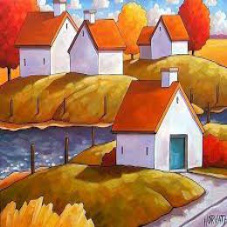

In [52]:
a = Image.open(train_df.filepath[0])
a

## Make Dataset & DataLoader